In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZED_R2 import _dataset, VAE, study#, compare_distributions_binned_aux, compare_distributions_binned
from VAE_OPTIMIZATION_WD import compare_continuous, compare_integer


# For saving img
from os.path import join, basename, exists
from os import getcwd
dir_name = basename(getcwd())
img_dir = join(getcwd(), "images")
if not exists(img_dir):
    os.mkdir(img_dir)
variante= 'R2'
dir_name

[I 2021-09-05 14:29:21,136] Using an existing study with name 'Optimizing the VAE with R2 - BKG vs Reconstruction' instead of creating a new one.
[I 2021-09-05 14:29:21,205] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


'non_zeros'

In [2]:
# For saving ROC Values
currect_dir = getcwd()
os.chdir("..")
base_directory = getcwd()
os.chdir(currect_dir) 

import pickle

try:
    rocs_scores = pickle.load( open( join(base_directory, "generate_tables",  dir_name+"_"+variante+".p"), "rb" ) )
except:
    rocs_scores = {}

pickle.dump( rocs_scores, open( join(base_directory, "generate_tables", dir_name+"_"+variante+".p"), "wb" ) )

## Loading the Study

In [3]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 101
Best trial:
  Value: 0.9938682044608013
  Params: 
    alpha: 6116
    hidden_size: 33
    lr: 0.0005181071332200718
    n_layers_decoder: 2
    n_layers_encoder: 2
    n_units_decoder_l0: 265
    n_units_decoder_l1: 425
    n_units_encoder_l0: 160
    n_units_encoder_l1: 470
 TRIAL NUMBER: 74


### Optuna Graphs

In [4]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image(join(img_dir, dir_name+variante+"_optuna_hp_importance.png"))
fig.show()

In [5]:
fig = optuna.visualization.plot_optimization_history(study)
fig.write_image(join(img_dir, dir_name+variante+"_optuna_optm_history.png"))
fig.show()

## Anomaly Detection

### Load the model

In [6]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "r2-reconstruction_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_R2-Data_vs_Reconstruction_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=160, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=160, out_features=470, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=470, out_features=33, bias=True)
  )
  (hidden2mu): Linear(in_features=33, out_features=33, bias=True)
  (hidden2log_var): Linear(in_features=33, out_features=33, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=33, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=425, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=425, out_features=47, bias=True)
  )
)

### Load data

In [7]:
# Bkg
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334163, 47)

## Check if z ~ N(0,1)

In [8]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334163, 33)

<ipython-input-9-9516a5a32fb3>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



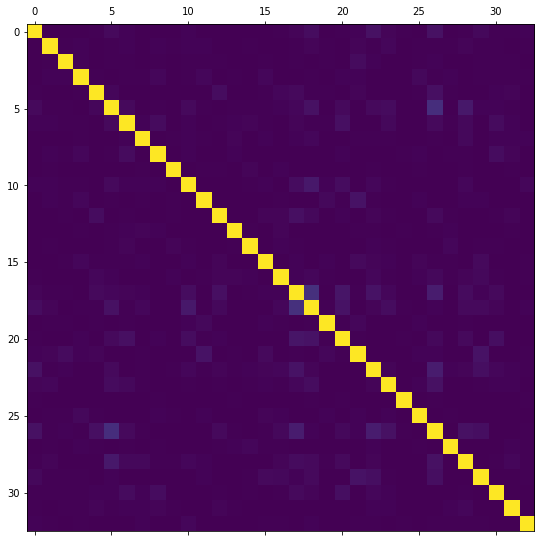

In [9]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

#axes = fig.add_subplot(1,2,i+1)
#i += 1
#axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.savefig(join(img_dir, dir_name+variante+"_correlation.png"), bbox_inches = 'tight')
fig.show()

In [10]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.13975
Mean:	 0.00829


Mean: -0.0033902817 	Std: 0.9997552
Mean: -0.007726 	Std: 1.0065452
Mean: -0.0055192863 	Std: 0.97309273
Mean: 0.009816392 	Std: 0.98938924
Mean: -0.020984909 	Std: 1.0047117
Mean: -0.010661511 	Std: 0.9969043
Mean: -0.04233169 	Std: 0.99919736
Mean: 0.017861443 	Std: 0.9979091
Mean: -0.0027364045 	Std: 0.99540824
Mean: -0.0012884847 	Std: 0.9753934
Mean: -0.038235415 	Std: 0.97987443
Mean: 0.009800878 	Std: 0.9968294
Mean: 0.02244834 	Std: 0.98962957
Mean: 0.0061847144 	Std: 0.9847859
Mean: 0.00827665 	Std: 0.9925769
Mean: 0.013504761 	Std: 0.99201196
Mean: 0.027420515 	Std: 0.9893806
Mean: 0.009362495 	Std: 0.99656653
Mean: 0.0022395249 	Std: 0.9953737
Mean: 0.00018721841 	Std: 0.99088186
Mean: -0.021473566 	Std: 0.9842896
Mean: 0.027020536 	Std: 0.9946399
Mean: 0.018976746 	Std: 1.0196607
Mean: -0.030380389 	Std: 1.0176027
Mean: 0.005052404 	Std: 0.9857231
Mean: -0.027495788 	Std: 0.9870816
Mean: -0.026618749 	Std: 1.0213646
Mean: 0.0013876809 	Std: 0.99162114
Mean: -0.004550984 	St

<ipython-input-11-1d03cc6f2ab4>:21: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



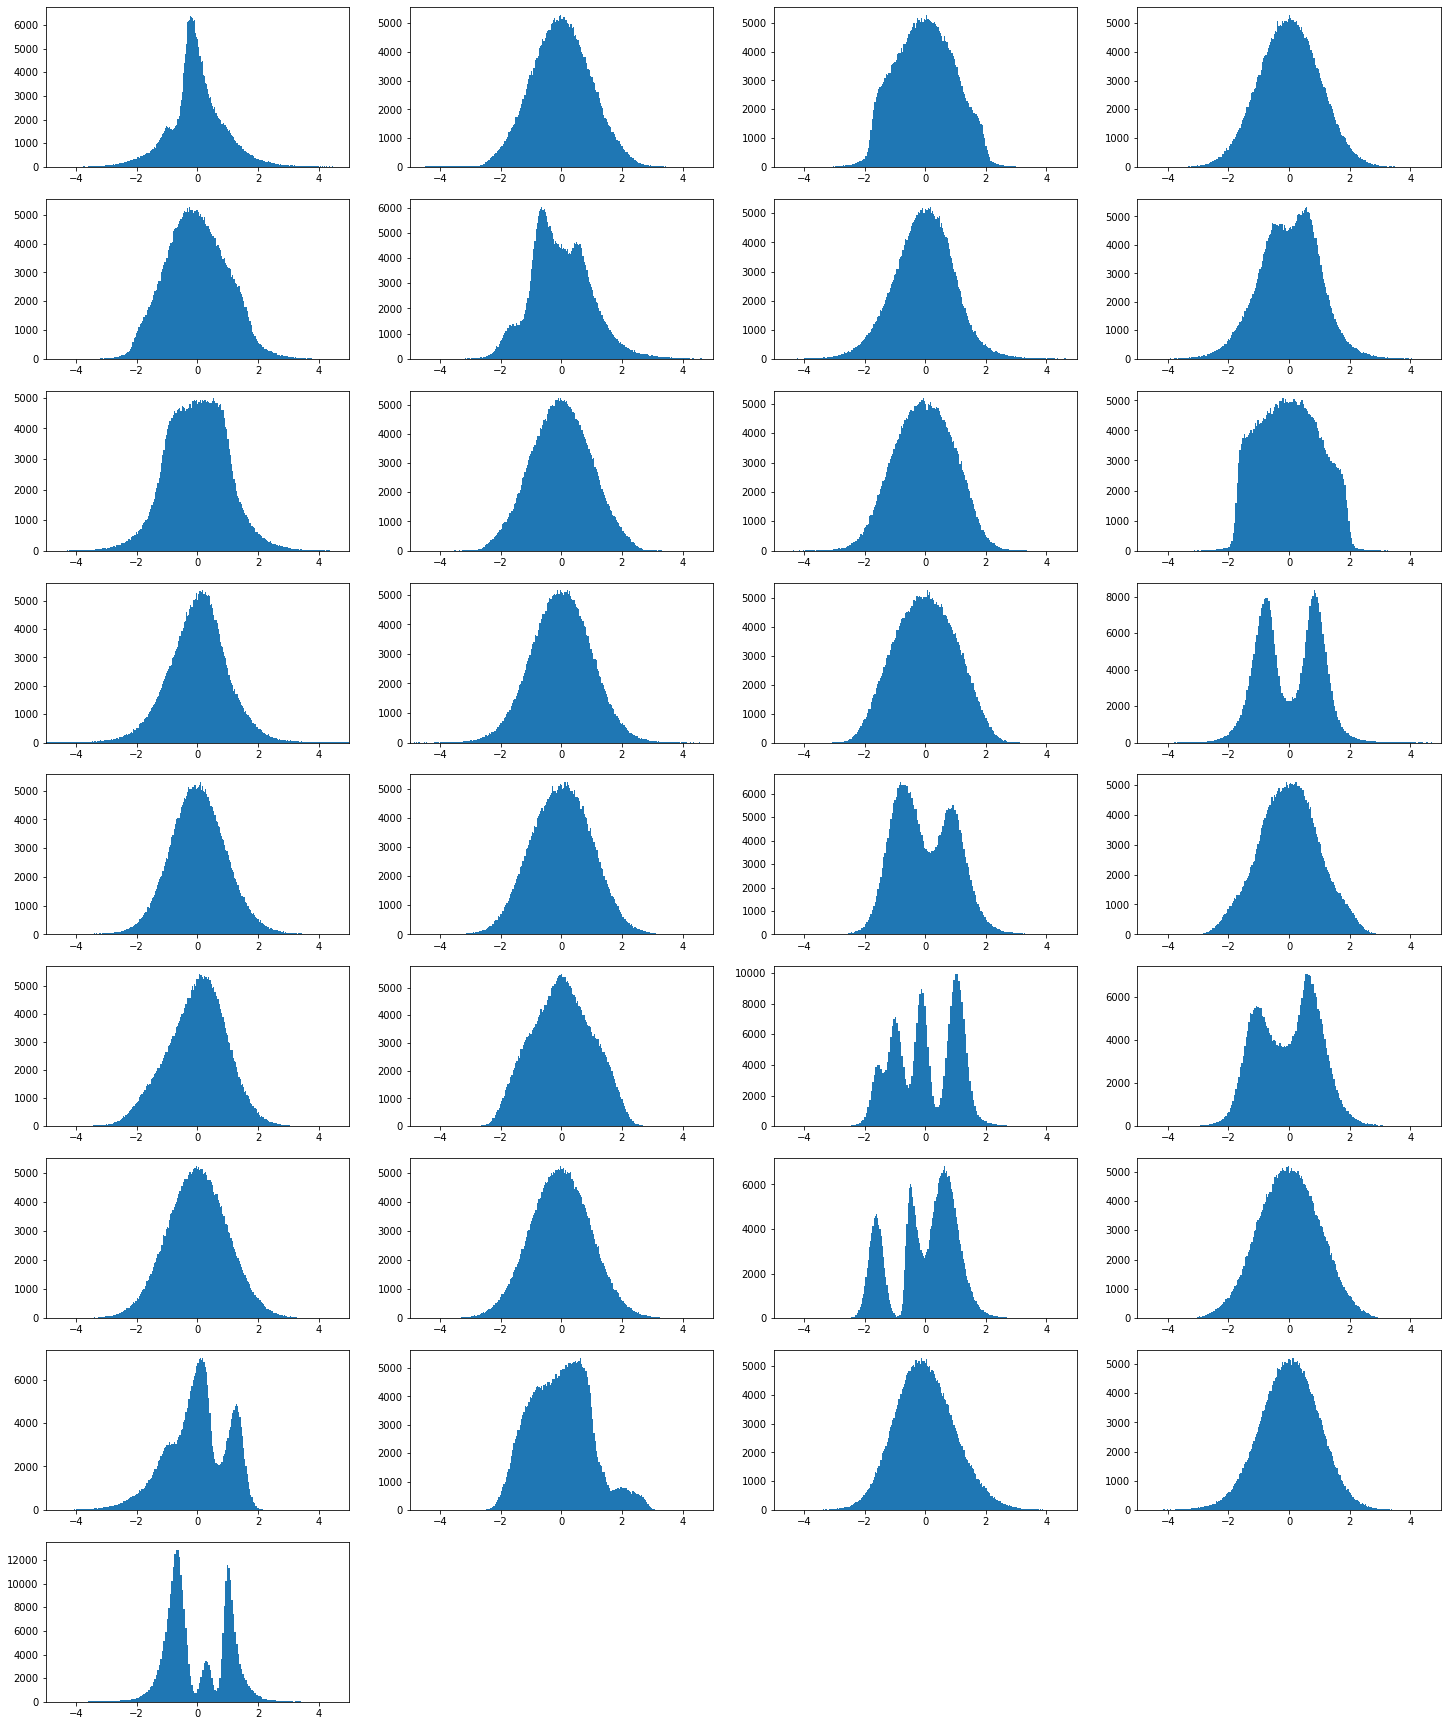

In [11]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.savefig(join(img_dir, dir_name+variante+"_zdim_Dist.png"), bbox_inches = 'tight')
fig.show()

## Bkg Data vs Random Sampling Decoding

In [12]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

Electron_Multi    FatJet1_Eta   FatJet1_Mass     FatJet1_PT  \
count   334163.000000  334163.000000  334163.000000  334163.000000   
mean         0.555639       0.223515       0.666880      -0.273819   
std          0.461706       0.287343       0.291802       0.167231   
min         -0.922447      -0.626523      -0.218065      -0.864125   
25%          0.210252       0.014371       0.452840      -0.391519   
50%          0.217077       0.224229       0.669098      -0.279132   
75%          1.121904       0.437902       0.878549      -0.162017   
max          1.286013       1.240102       1.653282       0.467680   

         FatJet1_Phi   FatJet1_Tau1   FatJet1_Tau2   FatJet1_Tau3  \
count  334163.000000  334163.000000  334163.000000  334163.000000   
mean       -0.029074       0.470606       0.286690       0.390176   
std         0.345023       0.393796       0.368880       0.387038   
min        -0.886457      -0.476929      -0.458288      -0.520829   
25%        -0.291887       0.154793      -0.012204       0.053209   
50%        -0.070812       0.463715       0.245726       0.371205   
75%         0.194627       0.788215       0.524719       0.718853   
max         1.397223       1.573962       1.792036       1.378016   

        FatJet1_Tau4   FatJet1_Tau5  ...    Lepton1_Eta     Lepton1_PT  \
count  334163.000000  334163.000000  ...  334163.000000  334163.000000   
mean        0.408288       0.393981  ...       0.808869      -0.169462   
std         0.400752       0.414157  ...       0.306686       0.223280   
min        -0.552420      -0.701816  ...      -0.176080      -1.036465   
25%         0.065994       0.050233  ...       0.584481      -0.324821   
50%         0.387721       0.370502  ...       0.808822      -0.172974   
75%         0.742159       0.728635  ...       1.032431      -0.016120   
max         1.391754       1.458546  ...       1.795897       0.682794   

         Lepton1_Phi    Lepton2_Eta     Lepton2_PT    Lepton2_Phi  \
count  334163.000000  334163.000000  334163.000000  334163.000000   
mean        1.134567       0.278272      -0.464272       1.026530   
std         0.359429       0.297920       0.196757       0.383054   
min        -0.058672      -0.706247      -1.000836       0.135836   
25%         0.898421       0.061743      -0.606576       0.702176   
50%         1.199671       0.278183      -0.473639       1.029543   
75%         1.408466       0.493925      -0.330436       1.354136   
max         1.908281       1.259484       0.356458       1.758776   

       MissingET_MET  MissingET_Phi     Muon_Multi    ScalarHT_HT  
count  334163.000000  334163.000000  334163.000000  334163.000000  
mean       -0.068442       0.176061      -0.557593      -0.372837  
std         0.300400       0.335248       0.464320       0.233156  
min        -0.697254      -0.747864      -1.291969      -1.059180  
25%        -0.323683      -0.067846      -1.127030      -0.543971  
50%        -0.073070       0.170634      -0.216885      -0.391795  
75%         0.179215       0.411040      -0.210544      -0.209287  
max         0.643858       1.222581       0.923593       0.581193  

[8 rows x 47 columns]

In [13]:
bkg.shape, sample.shape

((334163, 47), (334163, 47))

In [14]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

    fig.tight_layout()
    fig.savefig(join(img_dir, dir_name+variante+f"_{second_name}_vs_bkg.png"), bbox_inches = 'tight')
    fig.show()

<ipython-input-14-fd11cf38c044>:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



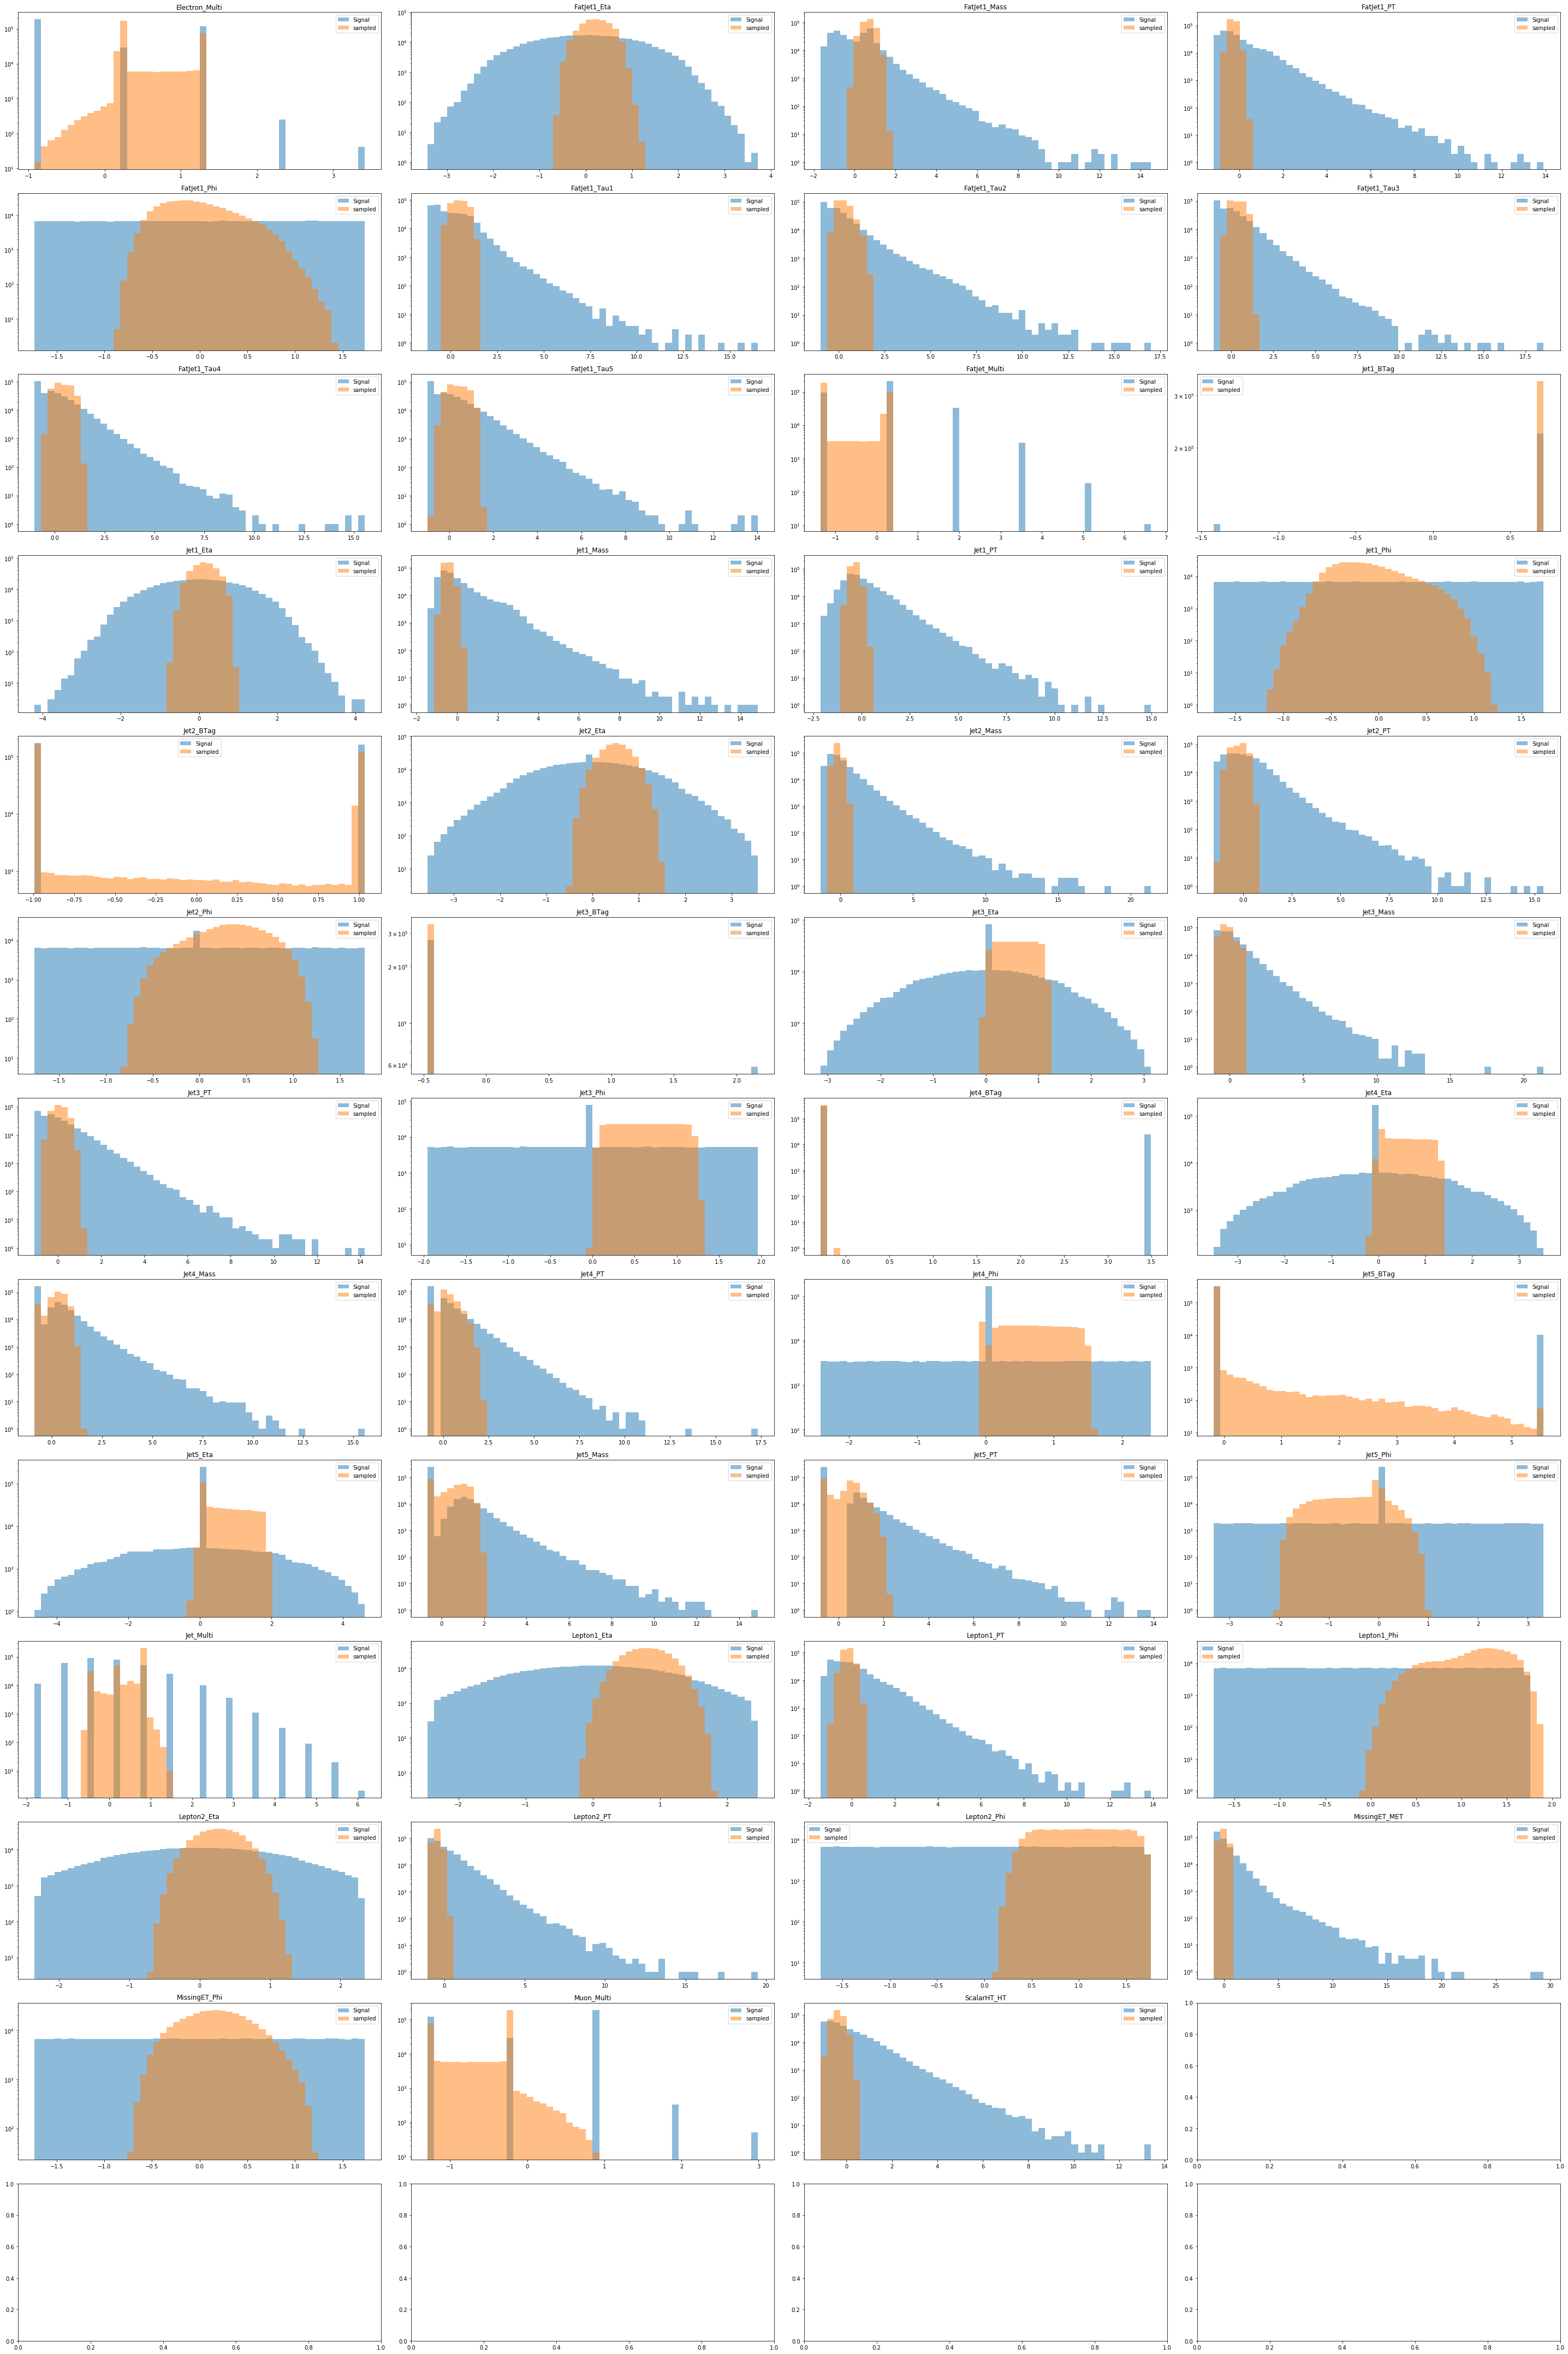

In [15]:
plot_graphs2(bkg, sample)

In [16]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 8.522109303161926


## Bkg Data vs Reconstruction

<ipython-input-14-fd11cf38c044>:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



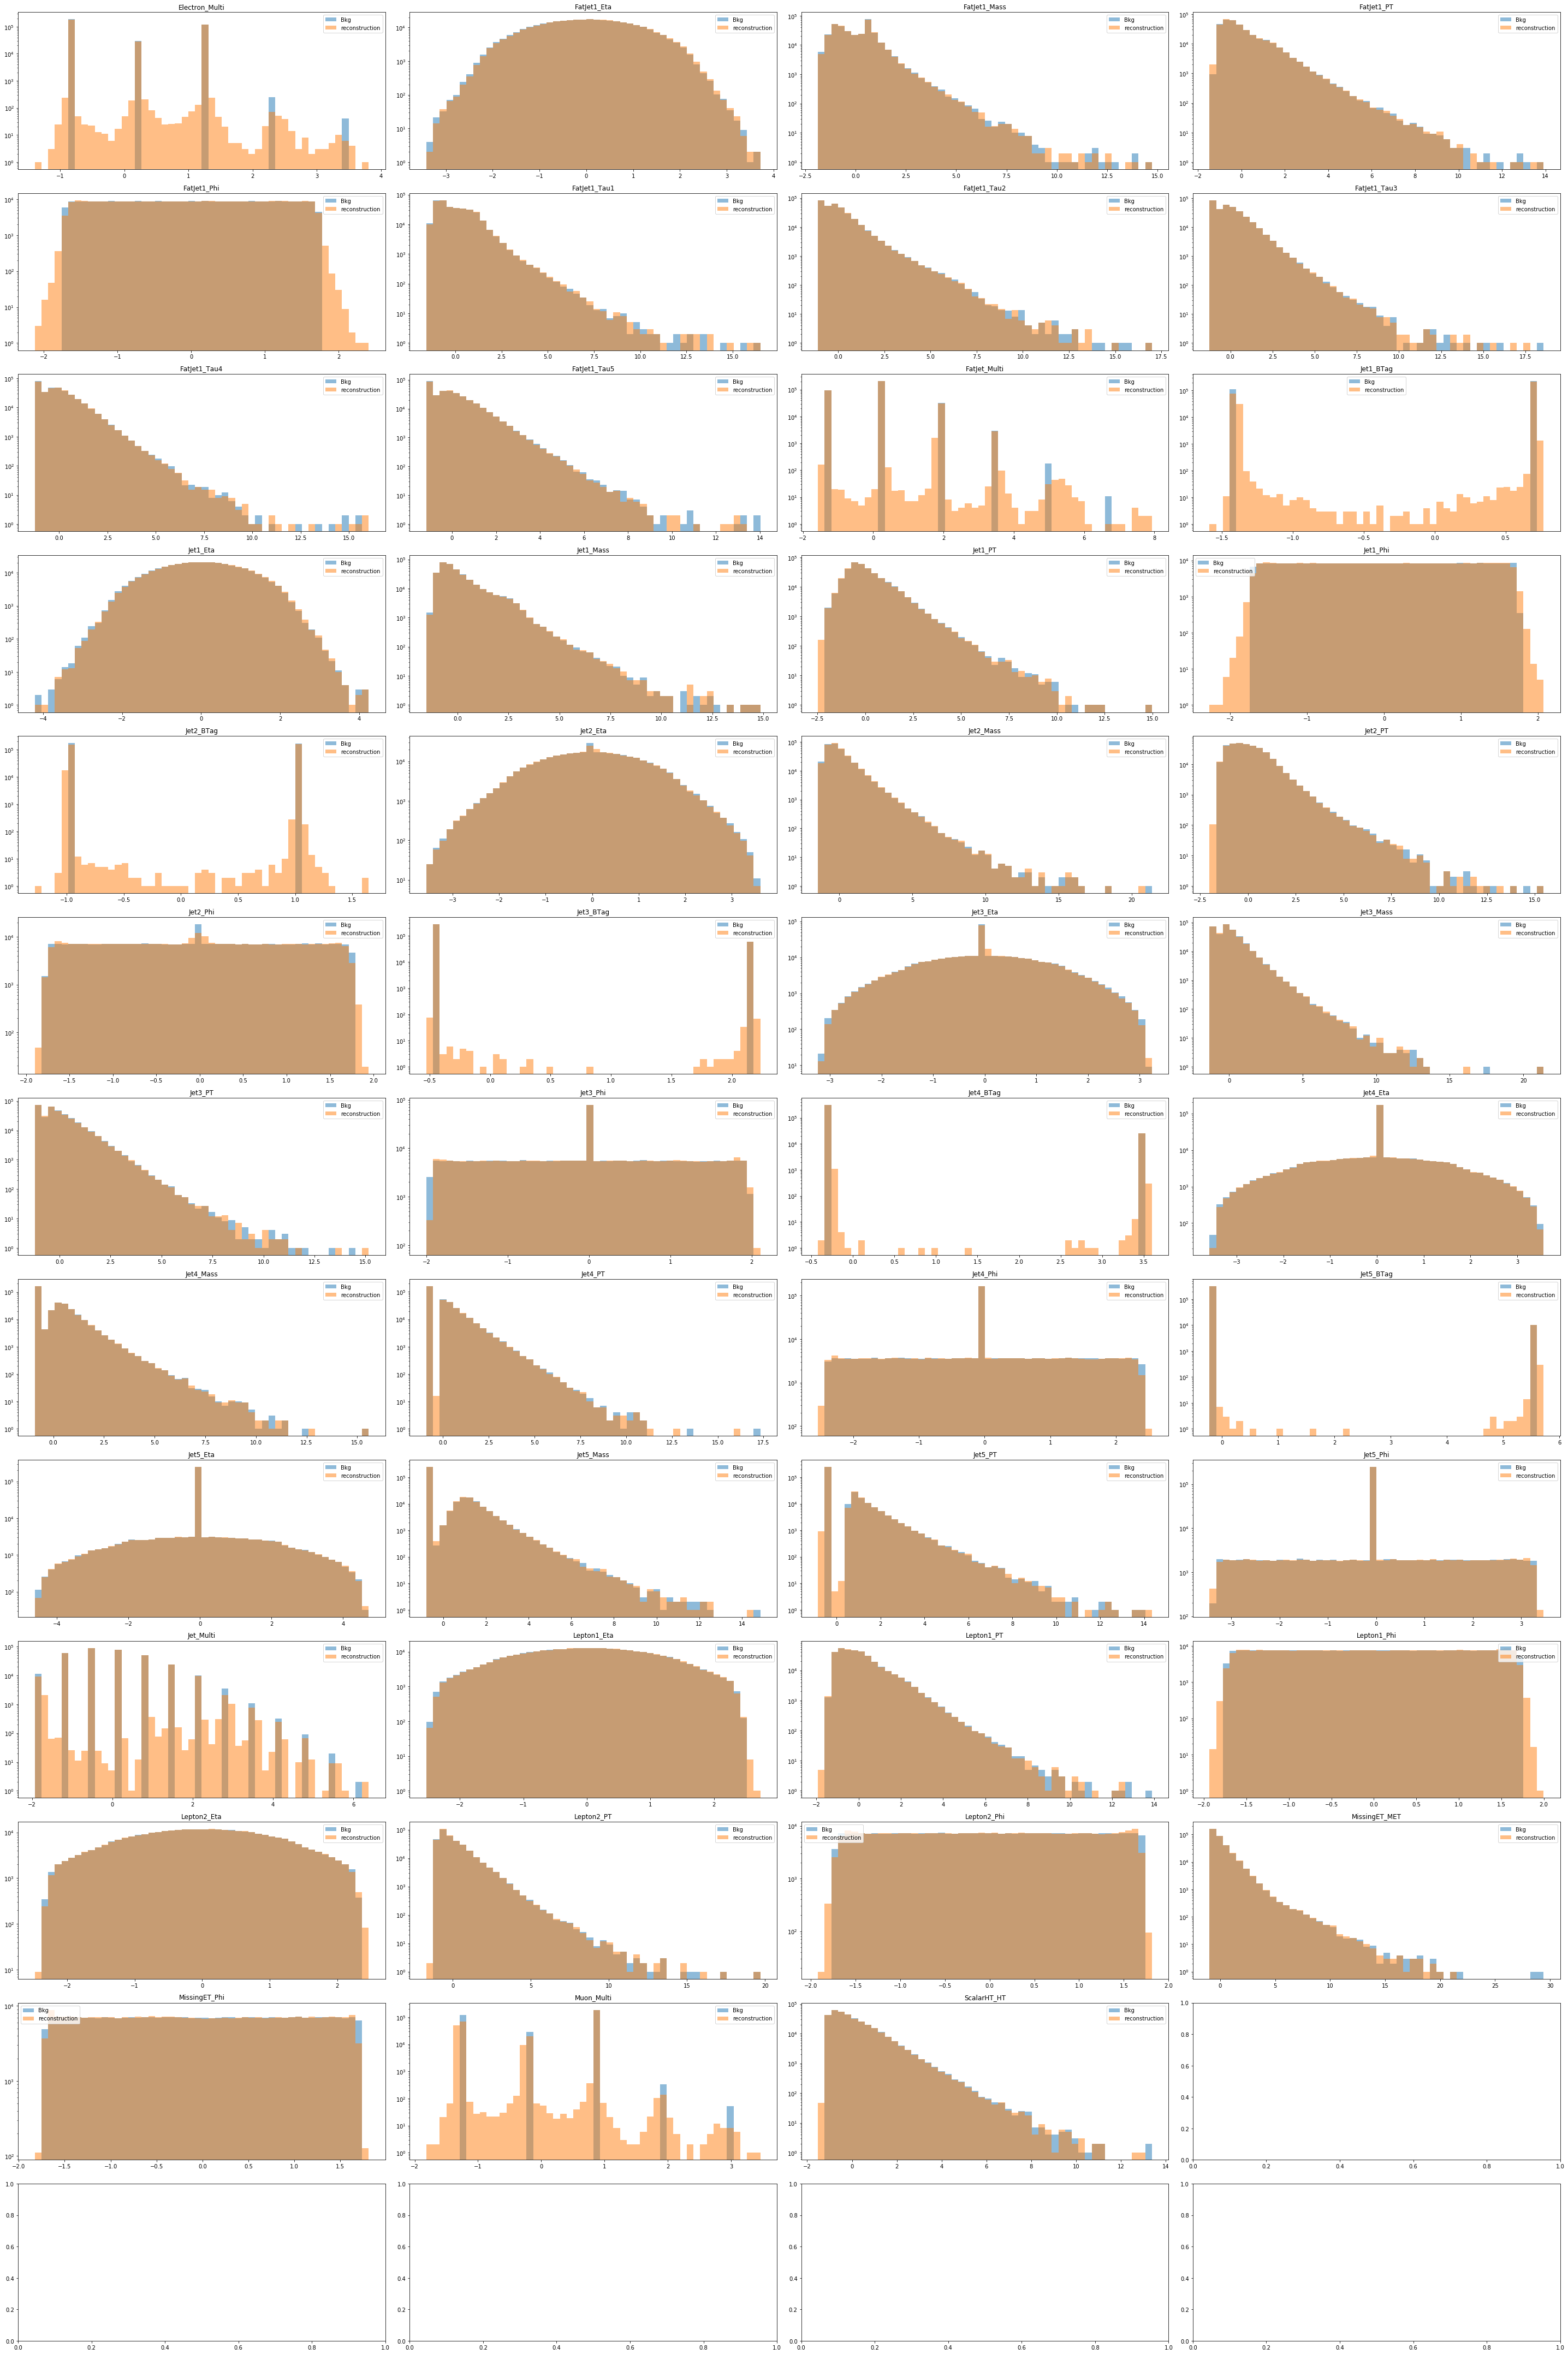

In [17]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="reconstruction")

In [18]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.9965922031523867


## Plot error distributions and ROC Score

Load data

In [19]:
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()

data = pd.concat([signal, bkg])
del signal, bkg


Plot

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    rocs = {}
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            

            auc_score = roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights)
            namee = x.replace('.h5', '')

            rocs_scores[namee] = auc_score
            print(f"ROC SCORE for {namee}:", auc_score)
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()
    fig_roc.savefig(join(img_dir, dir_name+variante+"_rocs.png"), bbox_inches = 'tight')
    fig.savefig(join(img_dir, dir_name+variante+"_error_dist.png"), bbox_inches = 'tight')

    # Save rocs to pickle
    pickle.dump( rocs_scores, open( join(base_directory, "generate_tables", dir_name+"_"+variante+".p"), "wb" ) )

ROC SCORE for fcnc: 0.9951284212032463
Confusion matrix:
[[334107     56]
 [ 88643   1435]]


ROC SCORE for hg3000_hq1400: 0.999916151169995
Confusion matrix:
[[334107     56]
 [  2394  23158]]


ROC SCORE for hg3000_hq1200: 0.9999153297470468
Confusion matrix:
[[334107     56]
 [  2476  24078]]


ROC SCORE for wohg_hq1000: 0.9999126002317623
Confusion matrix:
[[334107     56]
 [  2880  25341]]


ROC SCORE for wohg_hq1200: 0.9999144664736889
Confusion matrix:
[[334107     56]
 [  2500  23961]]


ROC SCORE for hg3000_hq1000: 0.999913505500927
Confusion matrix:
[[334107     56]
 [  2786  25393]]


ROC SCORE for wohg_hq1400: 0.9999089078707356
Confusion matrix:
[[334107     56]
 [  2670  22487]]





<ipython-input-20-a0ea9cc86ec4>:103: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



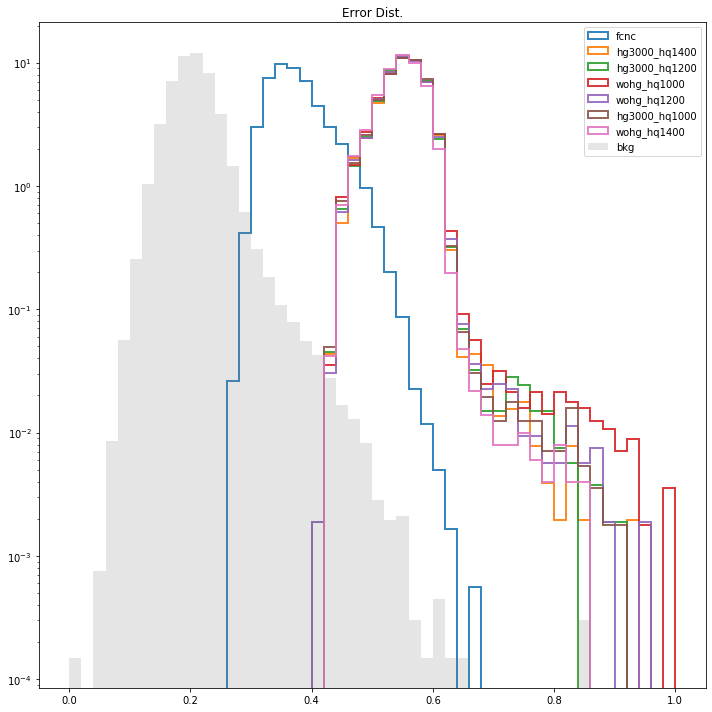

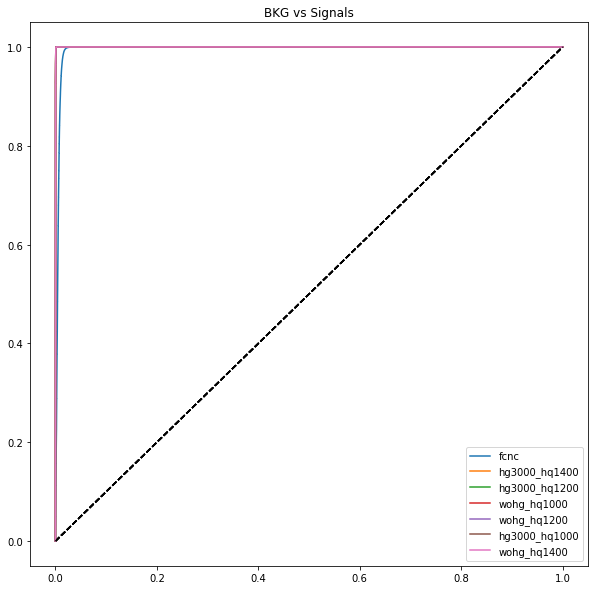

In [21]:
plot_graphs3(data)